In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
%matplotlib inline
import datatable

In [2]:
# Read original tweet file
df = datatable.fread("./data/input_data.csv").to_pandas()
print(df.columns)

Index(['C0', 'timestamp', 'has_media', 'hashtags', 'is_replied', 'is_reply_to',
       'likes', 'links', 'replies', 'reply_to_users', 'retweets', 'text',
       'timestamp_epochs', 'year', 'month', 'day'],
      dtype='object')


['\n2011', '2012', '\n2013', '2014', '\n2015', '2016', '\n2017', '2018', '\n2019']


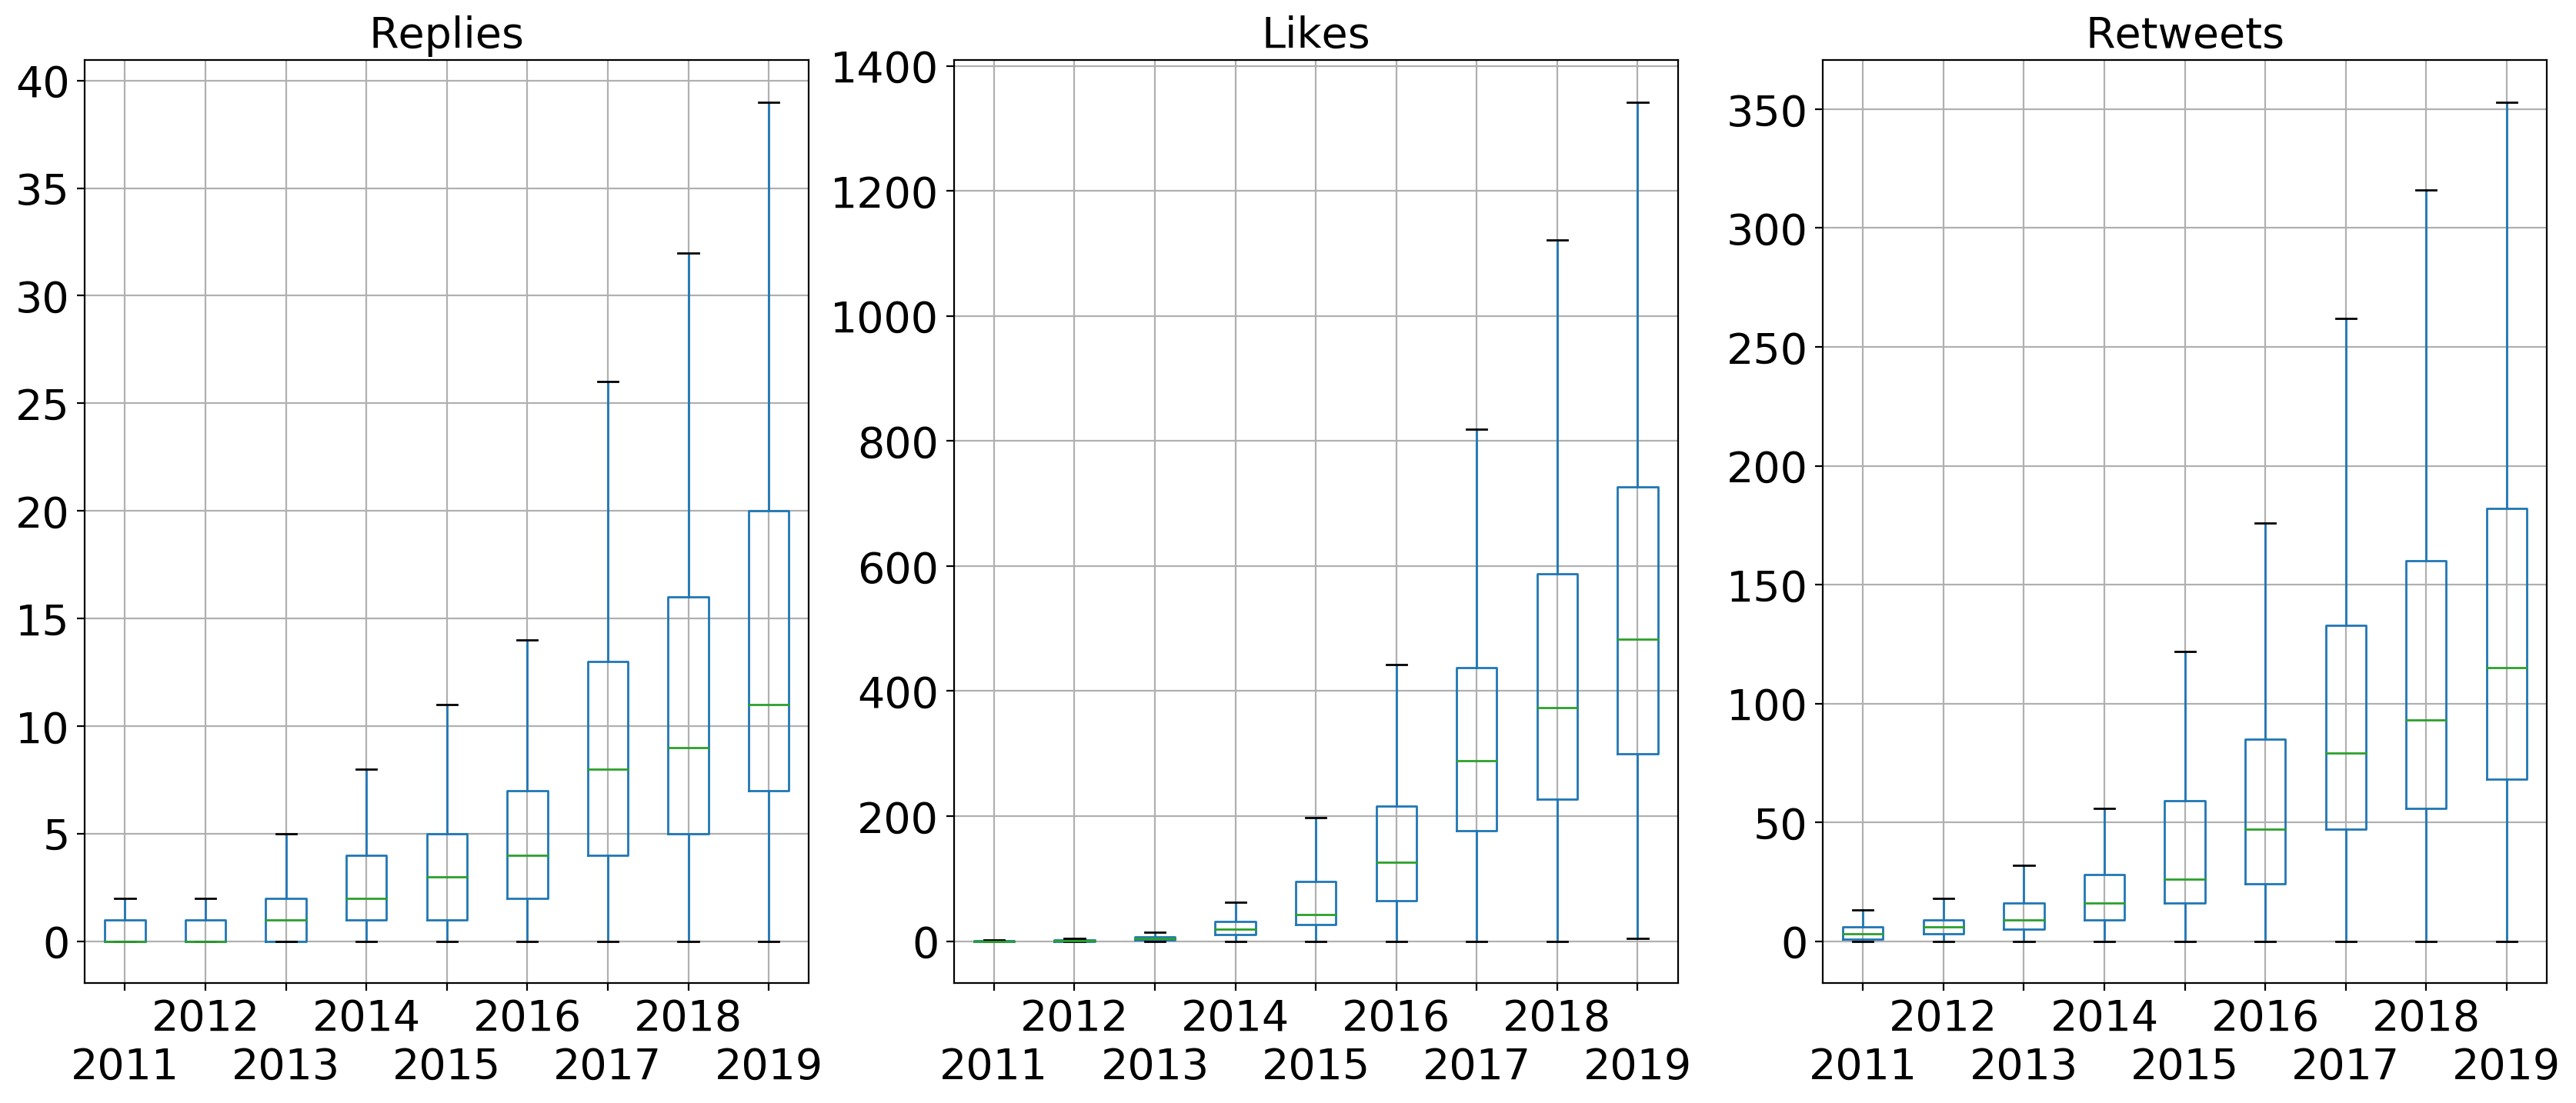

In [3]:
# plot distribution of target_variables over time
_fontsize=20
target_columns = ["replies", "likes", "retweets"]
fig, ax = plt.subplots(1, 3, figsize=(20, 8), dpi=200)

# hack to make 2-line labels
xlabels = []

for numm, k in enumerate(list(df.year.unique())):
    if numm % 2 != 0:
        xlabels.append(f"{k}")
    else:
        xlabels.append(f"\n{k}")
print(xlabels)
xi = list(range(1, len(xlabels) + 1))
        
for num, tvar in enumerate(target_columns):
    _title = f"{tvar[0].capitalize()}{tvar[1:]}"
    fig.add_subplot(df.boxplot(ax=ax[num], column=tvar, by='year', showfliers=False), sharey=False)
    ax[num].set_title("", fontsize=_fontsize)
    ax[num].tick_params(labelsize=_fontsize)
    ax[num].set_xlabel("")
    plt.yticks(fontsize=_fontsize)
    fig.suptitle("", fontsize=_fontsize*1)
    ax[num].set_title(_title, fontsize=_fontsize)
    plt.xticks(xi, xlabels)

import os
try:
    os.mkdir("./4article")
except OSError:
    None
plt.savefig("./4article/boxplots.png")

In [4]:
# Select only tweets published after 2016
df.drop(df[(df["year"] <= 2016)].index, inplace=True)
tweet_amount_after_2016 = len(df)
print("Number of tweets published after 2016: ", tweet_amount_after_2016)

Number of tweets published after 2016:  4853


In [5]:
# PREPROCESS TEXT
# preprocess data, inspired by "Twitter_Sentiment_Classification_using_Distant_Supervision.pdf"
import re
df_sampled = df.copy()

# change all pic.twitter.com to "IMAGE"
df_sampled["text"] = df_sampled["text"].str.replace('pic.twitter.com/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' _IMAGE', regex=True)

# # get rid of some instances of IMG
df_sampled["text"] = df_sampled["text"].str.replace('https://pbs.twimg.com/media/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'IMAGE', regex=True)

# get rid of some instances of https://twitter.com -> to RETWEET
df_sampled["text"] = df_sampled["text"].str.replace('https://twitter.com(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' _RETWEET', regex=True)

# change all URLS to "URL"
df_sampled["text"] = df_sampled["text"].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' _URL', regex=True)

# get rid of some instances of URL#some_url to URL
df_sampled["text"] = df_sampled["text"].str.replace('URL#(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' _URL', regex=True)

# replace repeating characters so that only 2 repeats remain
def repoo(x):
    repeat_regexp = re.compile(r'(\S+)(\1{2,})')
    repl = r'\2'
    return repeat_regexp.sub(repl=r'\2', string=x)


# to catch up to 10 repeats
for i in range(10):
    df_sampled["text"] = df_sampled["text"].map(lambda x: repoo(str(x)))

# get rid of endline signs
df_sampled["text"] = df_sampled["text"].str.replace("\n", "")

In [6]:
# prepare for counting tokens in tweets
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
from syntok.tokenizer import Tokenizer

tok = Tokenizer()

[nltk_data] Downloading package stopwords to /home/fiok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# A filtering function for removing tweets that only contain an image or url

import re
threshold = 2
token_length_list = []
# regex for normal letters and numbers except _
regex = r"(?<![\"=\w])(?:[^\W_]+)(?![\"=\w])"

def tweet_remove(y):
    # PREPROCESS WITH REGEX
    x = str(y).replace("_USArmy Posted... _URL …", "")
    x = re.sub(r"@\S*", "", x)
    x = re.sub(r"_IMAGE\S*", "", x)
    x = re.sub(r"…", "", x)  
    x = re.sub(r"_URL\S*", "", x)
    x = re.sub(r"_RETWEET\S*", "", x)
    x = re.sub(r"http[s]?://(\S+)", "", x)
    x = re.sub(r"\xa0", "", x)
    x = re.sub(r' +', ' ', x)
    x = re.sub(r"-+", "-", x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"!+", ".", x)
    x = re.sub(r"…*", "", x)

    # DEPENDING ON TOKEN COUNT DELETE OR NOT
    t_count = 0
    token_list = []
    for token in tok.tokenize(x):
        t_count += 1
        token_list.append(token.value)
    z = [word for word in token_list if word not in stop_words]
    token_length_list.append(len(z))

    # if there are to little tokens
    if len(z) <= threshold:
        return "DELETE"
    
    # if there are too litle normal text words
    elif len(re.findall(regex, str(x))) <= 0:
        return "DELETE"
    
    else:
        # return the input string but with n-whitespaces reduced to single whitespaces
        y = re.sub(r' +', ' ', y)
        return y

In [8]:
# applying tweet_remove function
token_length_list = []
df_sampled["text2"] = df_sampled["text"]
df_sampled["text"] = (df_sampled["text"].map(lambda x: tweet_remove(x)))
df_sampled["tokens"] = token_length_list
df_sampled.drop(df_sampled["text"][(df_sampled["text"].str.contains("DELETE", regex=True) == True)].index, inplace=True)
print("Tweets removed by tweet_remove: ",tweet_amount_after_2016 - len(df_sampled))
df = df_sampled.copy()

Tweets removed by tweet_remove:  5


In [9]:
# drop duplicate rows according to tweet text. After changing actual urls, 
# image urls to tokens, many duplicated tweet text appear
df.drop_duplicates(subset=["text"], inplace=True)
print("length after dropping rows with duplicate text: ", len(df))

length after dropping rows with duplicate text:  4498


In [10]:
# Convert regression task into an easier group-classification: label data according to distribution of values

quantiles = [0.25, 0.75]
target_columns = ["replies", "likes", "retweets"]
distribution = {}
for target_column in target_columns:
    target_distribution = []
    for quantile in quantiles:
        target_distribution.append(df[target_column].quantile(quantile))
    distribution[target_column] = target_distribution

print(distribution)

def code_target(target, distribution):
    """
    Function to encode target variables
    """
    target = int(target)

    if target <= distribution[0]: 
        return "small"
    elif distribution[0] < target <= distribution[1]:
        return "moderate"
    elif distribution[1] < target:
        return "high"

# insert label columns into the dataframe
for key in distribution:
    distrib = distribution[key]
    df[f"_{key}"] = df[f"{key}"].map(lambda x: code_target(x, distrib))

{'replies': [5.0, 16.0], 'likes': [216.0, 593.0], 'retweets': [56.0, 162.0]}


In [113]:
# save to csv for DLLM training
chosen_columns = ["text"]
chosen_columns.extend([f"_{tname}" for tname in target_columns])
df_final = df[chosen_columns].copy()
df_final["row"] = [x for x in range(len(df))]
# rename columns
df_final.columns = ["sentence", "replies", "likes", "retweets", "row"]
# reorder columns for Flair
new_column_order = ["replies", "likes", "retweets", "sentence", "row"]
df_final = df_final[new_column_order]

# add other columns
other_columns = ['has_media', 'hashtags', 'is_replied', 'is_reply_to', 'links', 'reply_to_users',
       'timestamp_epochs', 'year', 'month', 'day']
df_final[other_columns] = df[other_columns]

# save the preprocessed file
df_final.to_csv("./data/from_USNavy_for_flair.csv")

In [114]:
# change format of target variable labels for further training in Flair framework
for tname in target_columns:
    df_final[f'{tname}'] = '__label__' + df_final[f'{tname}'].astype(str)

In [115]:
# 5 fold CV
# setup random state
np.random.seed(13)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
fold_number = 5
kf = KFold(n_splits=fold_number, random_state=13, shuffle=True)

In [116]:
# create data splits for Deep Learning Language Models trained with Flair framework
train_indexes = {}
val_indexes = {}
test_indexes = {}

# train sets for Machine Learning
train_ml = {}
i = 0

# this split (with fold_number=5) results in: 20% test, 10% val, 70% train for Flair framework
# and the same 20% test and 80 % train for Machine Learning
indexes = list(range(0, len(df_final)))
for train_index, test_index in kf.split(indexes):
    test_indexes[i] = test_index
    train_ml[i] = train_index
    train_index, val_index = train_test_split(train_index, test_size=0.125, random_state=13, shuffle=True)
    train_indexes[i] = train_index
    val_indexes[i] = val_index
    i += 1
    
# test sets for Machine Learning are equal to those for Flair framework
test_ml = test_indexes

In [117]:
# create folders for FLAIR data splits and .tsv files for training
import os
for tname in target_columns:
    folds_path1 = []
    df_temp = df_final.copy()
    df_temp = df_temp[[f"{tname}", "sentence", "row"]]
    for fold in range(fold_number):
        folds_path1.append('./data/model_{}_{}/'.format(tname, str(fold)))
        try:
            os.mkdir('./data/model_{}_{}/'.format(tname, str(fold)))
        except FileExistsError:
            None  # continue
        df_temp.iloc[test_indexes[fold]].to_csv(os.path.join(folds_path1[fold], "test_.tsv"), index=False, header=False, encoding='utf-8', sep='\t')
        df_temp.iloc[train_indexes[fold]].to_csv(os.path.join(folds_path1[fold], "train.tsv"), index=False, header=False, encoding='utf-8', sep='\t')
        df_temp.iloc[val_indexes[fold]].to_csv(os.path.join(folds_path1[fold], "dev.tsv"), index=False, header=False, encoding='utf-8', sep='\t')